In [1]:
import pandas as pd
import cv2
import sys
import os

sys.path.append("../../")

from src.dataset3D import MRIDataset3D

#utils.set_seed(42)

# 📂 Carga de CSV
results_dir = '../../results/preprocessed_data/'
df_train = pd.read_csv(os.path.join(results_dir, 'df_train.csv'))
df_test = pd.read_csv(os.path.join(results_dir, 'df_test.csv'))
df_train.head(2)

filename  Noise  Zipper  Positioning  Banding  Motion  \
0  LISA_0001_LF_axi.nii.gz      0       0            0        0       0   
1  LISA_0001_LF_cor.nii.gz      0       0            0        0       0   

   Contrast  Distortion                                               path  \
0         0           0  /data/cristian/projects/med_data/rise-miccai/t...   
1         0           0  /data/cristian/projects/med_data/rise-miccai/t...   

  patient_id  
0  LISA_0001  
1  LISA_0001

In [2]:
from scipy.ndimage import binary_erosion, binary_dilation, generate_binary_structure
import numpy as np
import torch
import matplotlib.pyplot as plt
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, Orientation
import copy

def extract_dense_near_max_slices_tile(volume: torch.Tensor, tile_rows: int, tile_cols: int, view_axis: str = "sag",
                                       normalize=True, std_factor=0.5, kernel_size: int = 3, debug : bool = False , reorientar : bool = True):
    """
    Encuentra las slices consecutivas con mayor contenido cerebral usando operaciones morfológicas
    con un kernel de tamaño personalizado para limpiar ruido. Extrae un bloque 2D (NxM) como mosaico.
    """
    assert volume.ndim == 4 and volume.shape[0] == 1, "Expected shape (1, D, H, W)"
    slices = volume[0].cpu().numpy()
    D, H, W = slices.shape
    total_slices = tile_rows * tile_cols
    if reorientar:
      # Reorient slices según vista
      if view_axis == "sag":
          slices = slices
      elif view_axis == "cor":
          slices = np.transpose(slices, (1, 0, 2))
      elif view_axis == "axi":
          slices = np.transpose(slices, (2, 0, 1))
      else:
          raise ValueError(f"Invalid view_axis: {view_axis}")

    num_slices = slices.shape[0]

    # Crear estructura morfológica (kernel cuadrado)
    structure = np.ones((5, 5), dtype=bool)
    structure_erode = np.ones((2, 2), dtype=bool)
    values = []
    for i in range(num_slices):
        ga = copy.deepcopy(slices[i])
        #ga = (ga-ga.min())/ga.max()
        mask = ga >= 0.15

        final  = binary_dilation(mask, structure=np.ones((2,2), dtype=bool))
        final  = binary_erosion(final, structure=np.ones((2,2), dtype=bool))
        final  = binary_dilation(final, structure=np.ones((2,2), dtype=bool))
        final  = binary_erosion(final, structure=np.ones((3,3), dtype=bool))
        final  = binary_dilation(final, structure=np.ones((3,3), dtype=bool))
        final  = binary_dilation(final, structure=structure)
        final  = binary_erosion(final, structure=structure_erode)

        values.append(np.count_nonzero(final))
    values = np.array(values)

    # Evaluar bloques de slices consecutivos
    scores = [(i, values[i:i + total_slices].sum()) for i in range(num_slices - total_slices + 1)]
    score_array = np.array([s for _, s in scores])
    max_score = score_array.max()
    std = score_array.std()
    lower = max_score - std_factor * std
    filtered = [(i, s) for i, s in scores if s >= lower]

    # Elegir el bloque más centrado
    center_idx = num_slices // 2
    # Elegir bloque más centrado respecto al volumen total
    max_idx = int(values.argmax())
    if not filtered:
        best_start = int(score_array.argmax())
    else:
        #center_idx = num_slices // 2
        best_start = min(filtered, key=lambda i: abs((i[0] + total_slices // 2) - max_idx))[0]

    selected = slices[best_start:best_start + total_slices]
    H, W = selected.shape[1:]
    canvas = np.zeros((tile_rows * H, tile_cols * W), dtype=np.float32)

    if debug:
      print("values max_idx:",max_idx)
      print("score_array:",score_array)
      print("max_score:",max_score)
      print("std:",std)
      print("filtered:",filtered)
      print("lower:",lower)
      print("best_start:",best_start)
      print("selected:",values[best_start:best_start + total_slices])



    for idx in range(total_slices):
        row = idx // tile_cols
        col = idx % tile_cols
        canvas[row * H:(row + 1) * H, col * W:(col + 1) * W] = selected[idx]

    if normalize:
        if debug:
          print("canvas.min():",canvas.min())
          print("canvas.max():",canvas.max())
        #canvas[canvas>1] = 1
        canvas -= canvas.min()
        canvas /= (canvas.max() + 1e-8)

    return canvas

/data/cristian/projects/med_data/rise-miccai/task-1/756/155881756/LISA_0064_LF_axi.nii.gz
Noise : 0 |Zipper : 0 |Positioning : 0 |Banding : 0 |Motion : 0 |Contrast : 1 |Distortion : 0 |


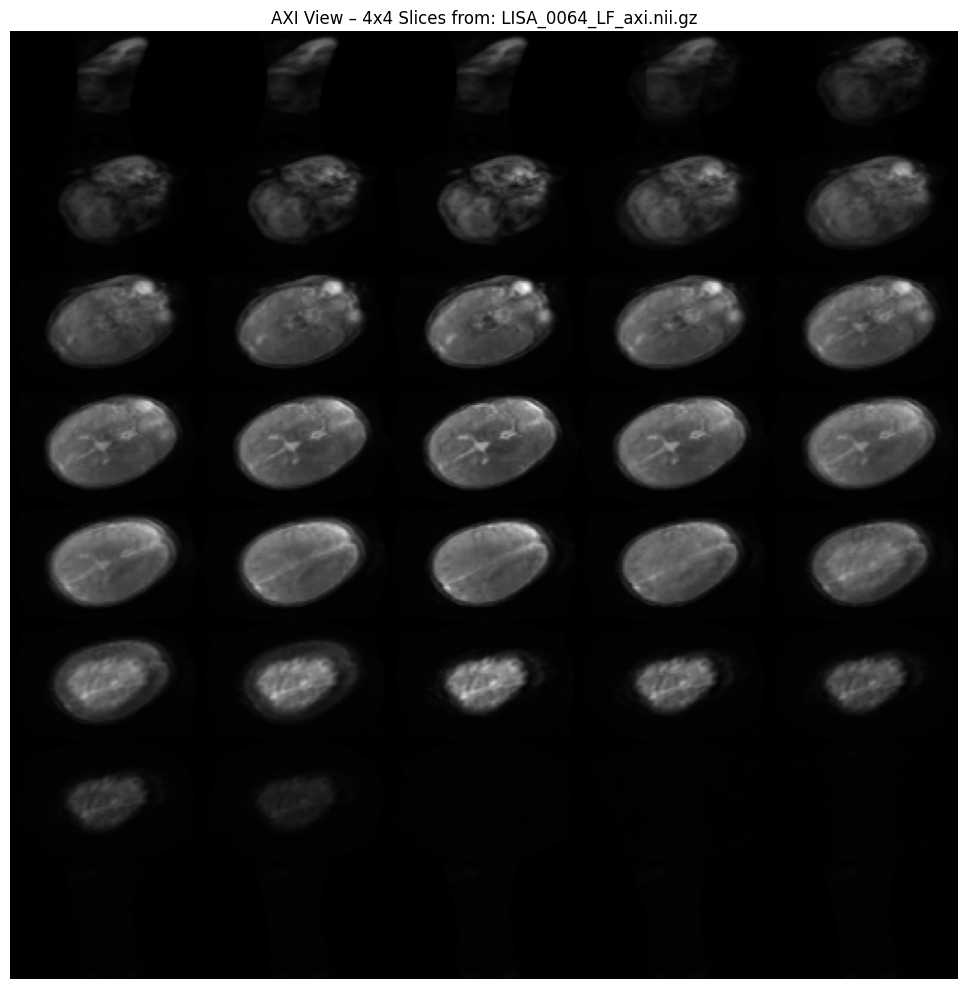

/data/cristian/projects/med_data/rise-miccai/task-1/214/155882214/LISA_2006_LF_axi.nii.gz
Noise : 2 |Zipper : 1 |Positioning : 2 |Banding : 0 |Motion : 0 |Contrast : 0 |Distortion : 0 |


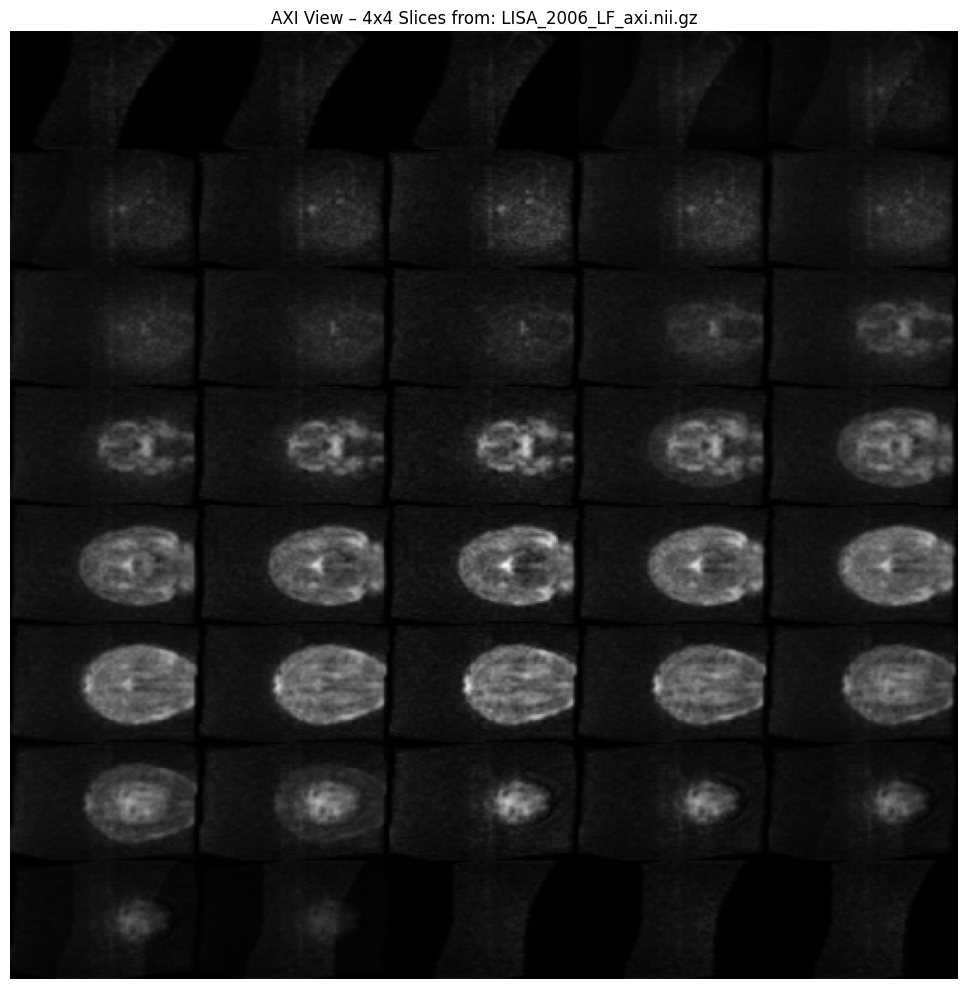

/data/cristian/projects/med_data/rise-miccai/task-1/219/155882219/LISA_2009_LF_cor.nii.gz
Noise : 0 |Zipper : 0 |Positioning : 2 |Banding : 0 |Motion : 2 |Contrast : 1 |Distortion : 2 |


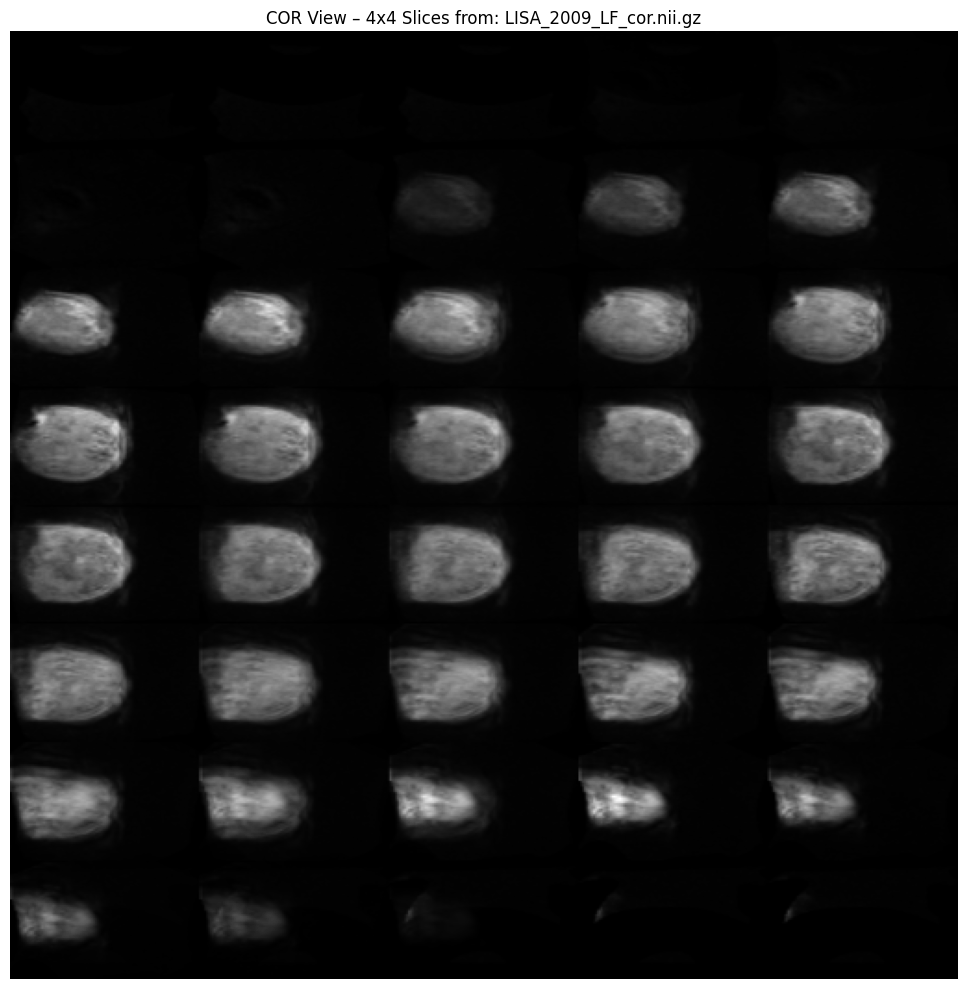

/data/cristian/projects/med_data/rise-miccai/task-1/255/155882255/LISA_2030_LF_axi.nii.gz
Noise : 0 |Zipper : 1 |Positioning : 2 |Banding : 0 |Motion : 0 |Contrast : 0 |Distortion : 0 |


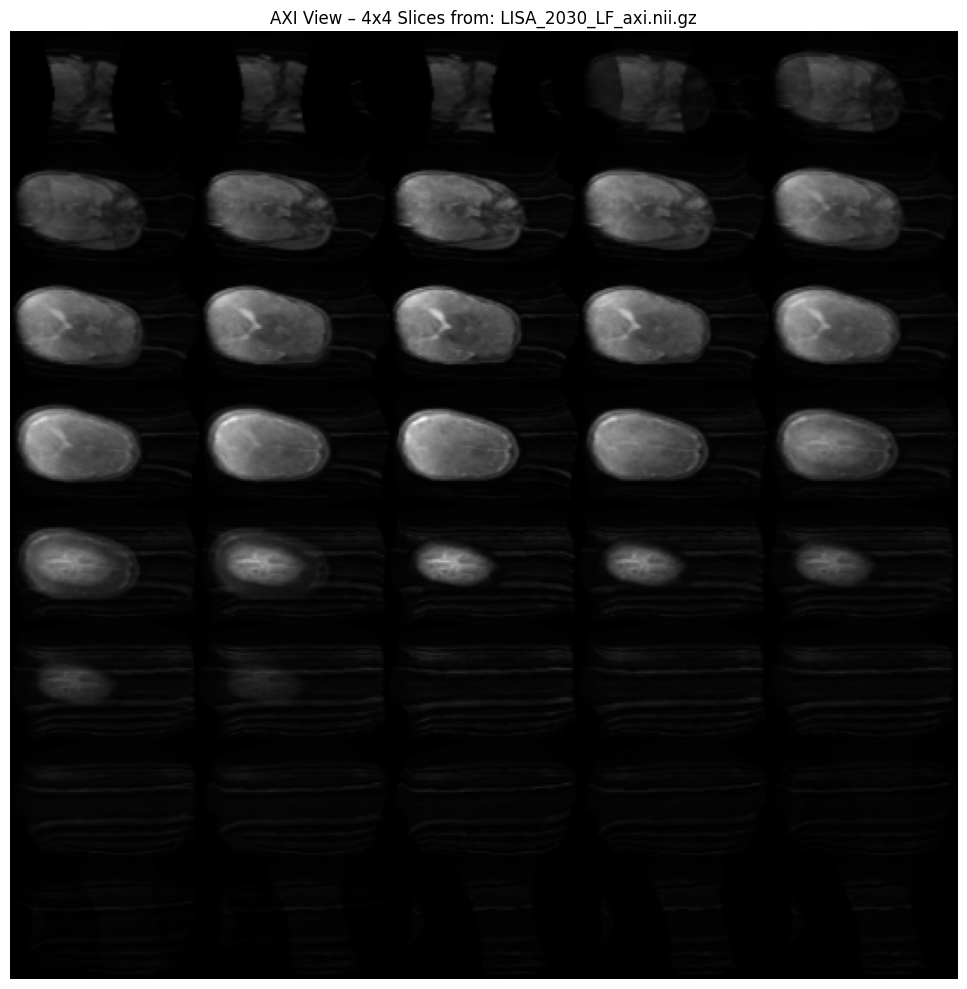

/data/cristian/projects/med_data/rise-miccai/task-1/783/155881783/LISA_0067_LF_sag.nii.gz
Noise : 1 |Zipper : 1 |Positioning : 0 |Banding : 0 |Motion : 0 |Contrast : 0 |Distortion : 1 |


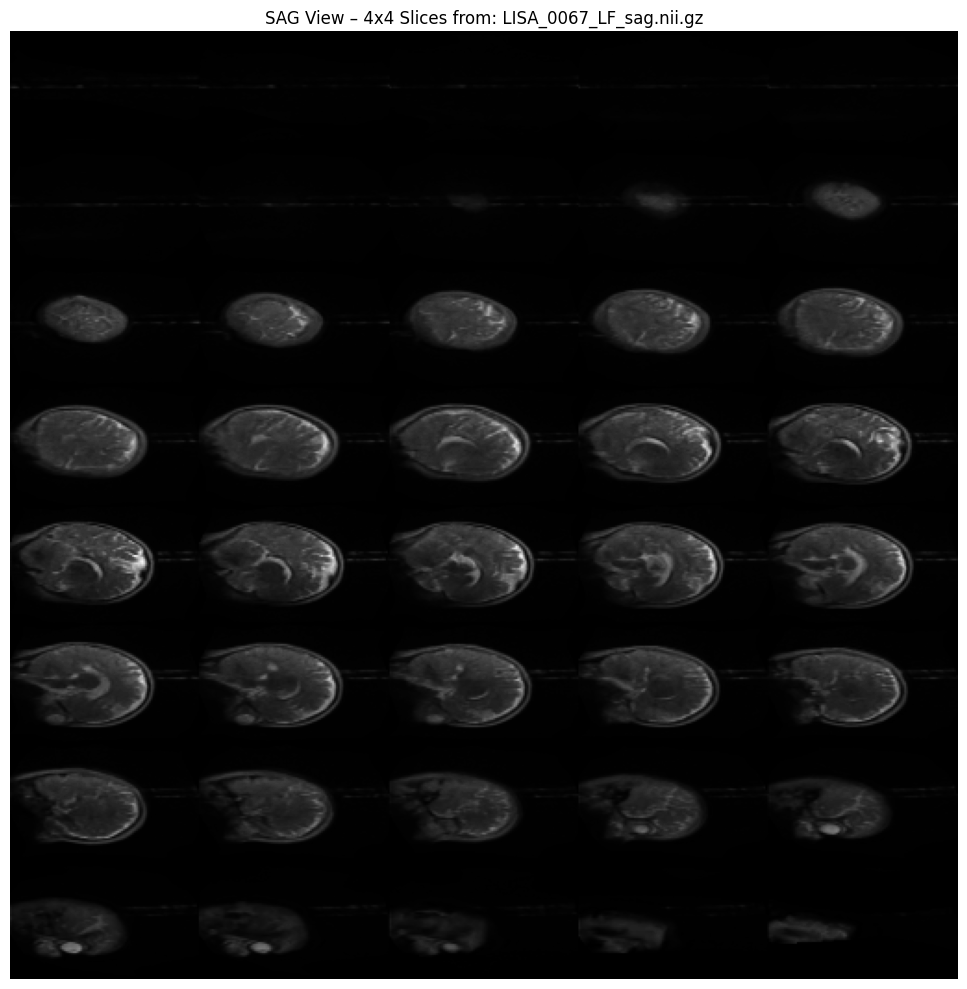

/data/cristian/projects/med_data/rise-miccai/task-1/57/155882057/LISA_1023_LF_sag.nii.gz
Noise : 0 |Zipper : 1 |Positioning : 1 |Banding : 0 |Motion : 0 |Contrast : 0 |Distortion : 0 |


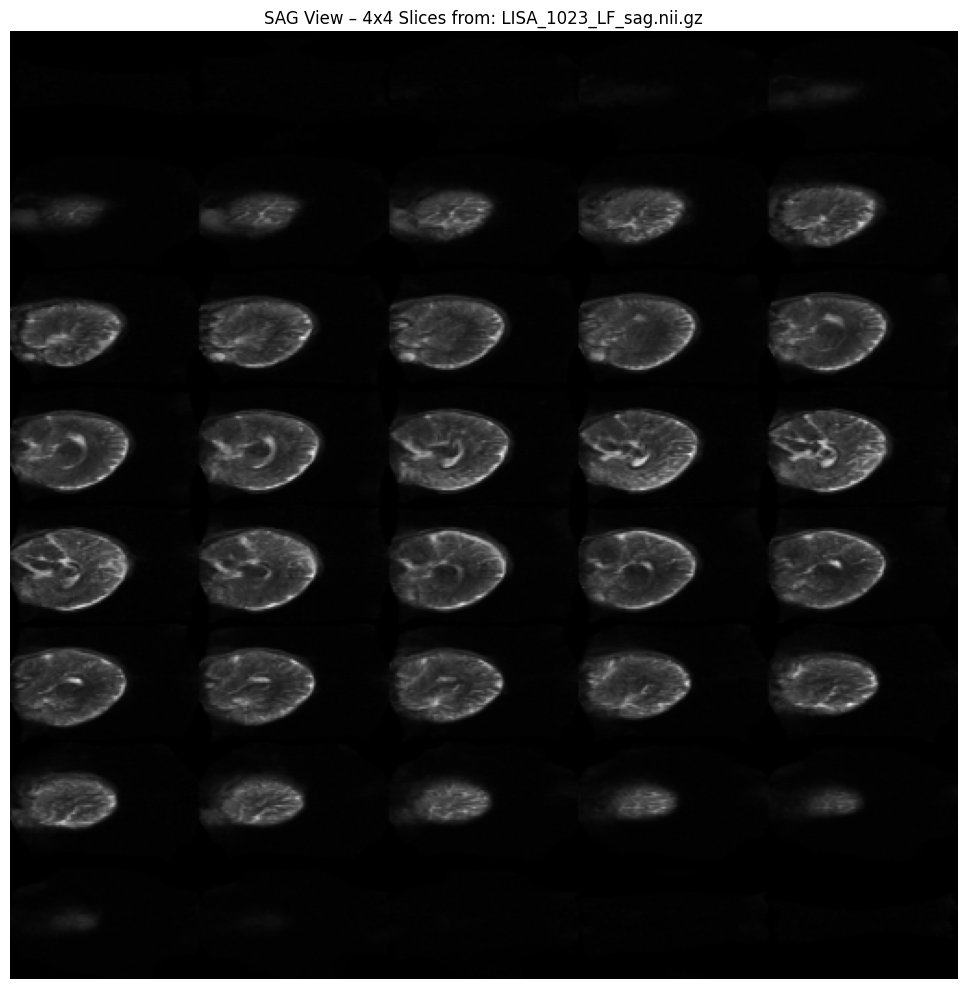

/data/cristian/projects/med_data/rise-miccai/task-1/308/155882308/LISA_2073_LF_sag.nii.gz
Noise : 1 |Zipper : 1 |Positioning : 0 |Banding : 0 |Motion : 2 |Contrast : 0 |Distortion : 2 |


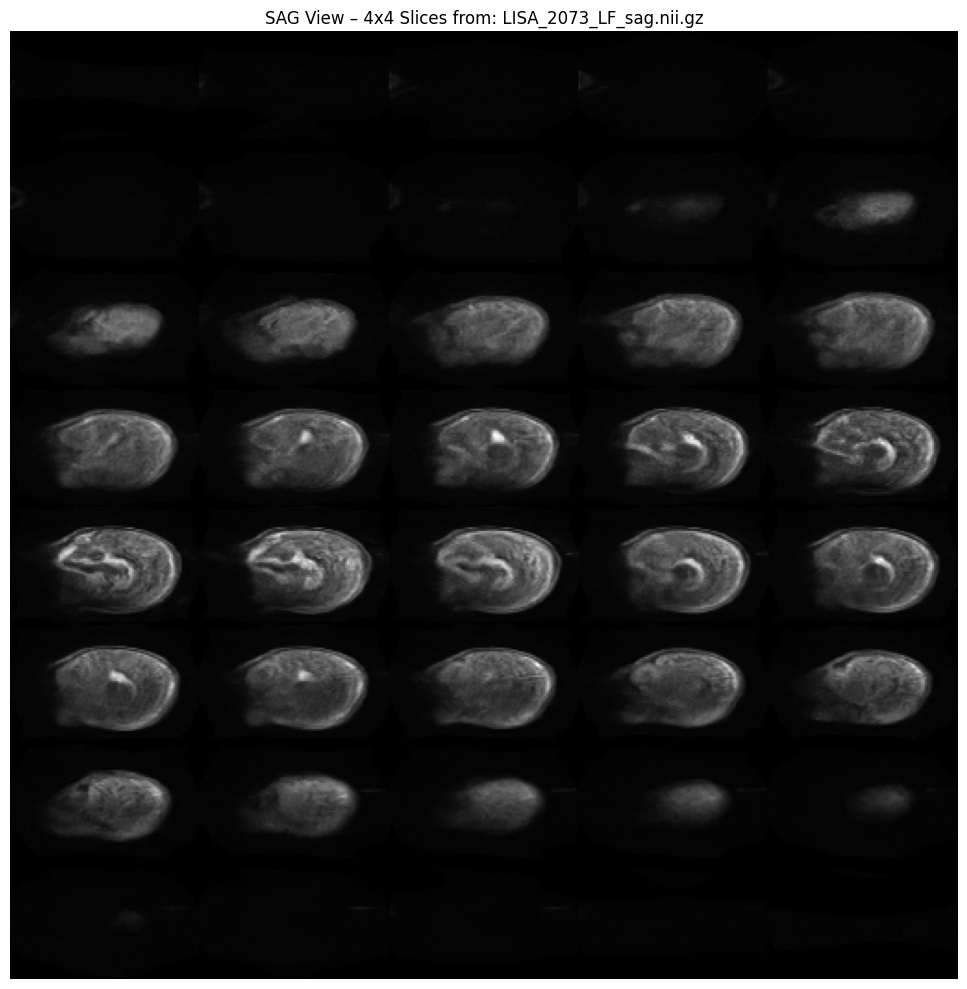

/data/cristian/projects/med_data/rise-miccai/task-1/223/155882223/LISA_2012_LF_sag.nii.gz
Noise : 0 |Zipper : 2 |Positioning : 0 |Banding : 2 |Motion : 0 |Contrast : 0 |Distortion : 2 |


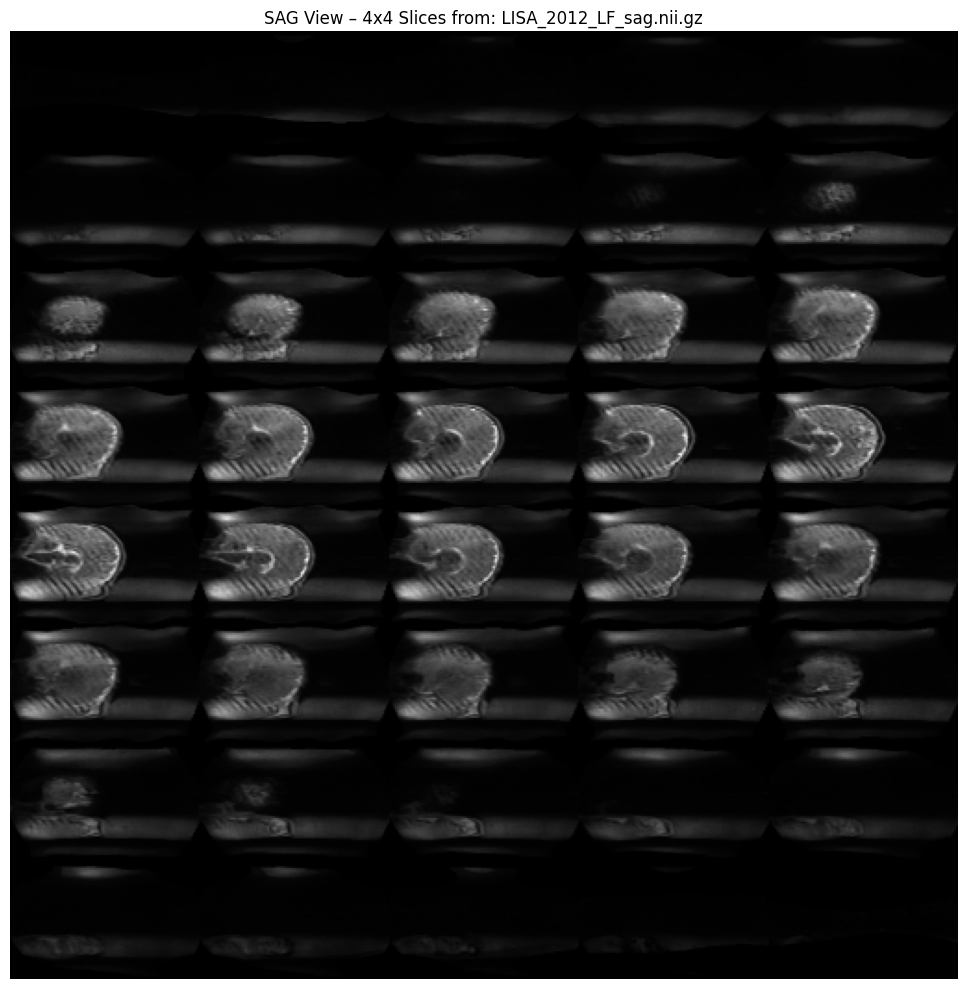

/data/cristian/projects/med_data/rise-miccai/task-1/491/155881491/LISA_0022_LF_sag.nii.gz
Noise : 0 |Zipper : 1 |Positioning : 0 |Banding : 0 |Motion : 0 |Contrast : 1 |Distortion : 2 |


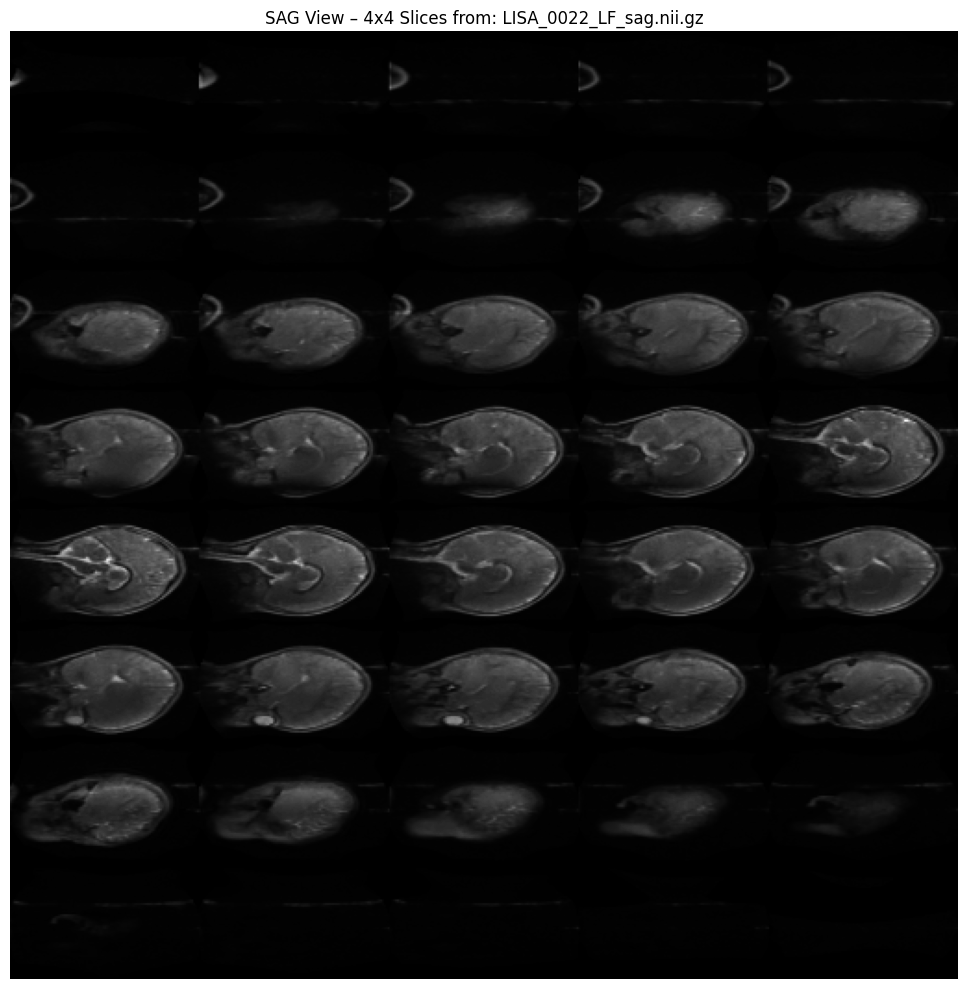

/data/cristian/projects/med_data/rise-miccai/task-1/513/159040513/LISA_2013_LF_sag.nii.gz
Noise : 0 |Zipper : 2 |Positioning : 0 |Banding : 0 |Motion : 0 |Contrast : 0 |Distortion : 2 |


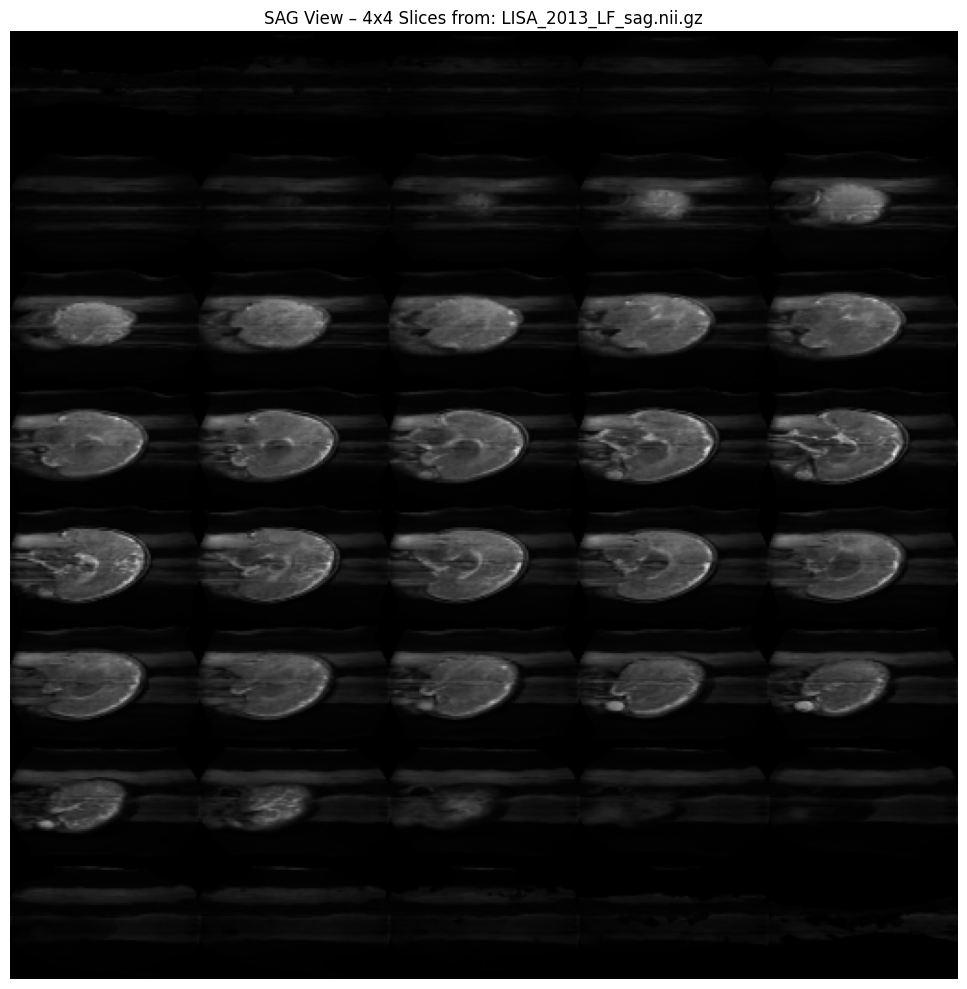

In [9]:
"""
"""
filenames = ["/data/cristian/projects/med_data/rise-miccai/task-1/756/155881756/LISA_0064_LF_axi.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/214/155882214/LISA_2006_LF_axi.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/219/155882219/LISA_2009_LF_cor.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/255/155882255/LISA_2030_LF_axi.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/783/155881783/LISA_0067_LF_sag.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/57/155882057/LISA_1023_LF_sag.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/308/155882308/LISA_2073_LF_sag.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/223/155882223/LISA_2012_LF_sag.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/491/155881491/LISA_0022_LF_sag.nii.gz",
"/data/cristian/projects/med_data/rise-miccai/task-1/513/159040513/LISA_2013_LF_sag.nii.gz"
             ]
LABELS =     ["Noise", "Zipper", "Positioning", "Banding", "Motion", "Contrast", "Distortion"]

for nifti_path in filenames:
  print(nifti_path)
  filename = nifti_path.split("/")[-1]


  df_nii = df_train[df_train["path"]==nifti_path].reset_index(drop=True)
  for label in LABELS:
    print(f"{label} : {df_nii[label][0]} |",end="")
  print()

  # Detectar vista por nombre
  if "_sag" in filename:
      view_axis = "sag"
  elif "_cor" in filename:
      view_axis = "cor"
  elif "_axi" in filename:
      view_axis = "axi"
  else:
      raise ValueError("No se pudo detectar la vista del archivo.")

  # 📋 Crear DataFrame mock para cargar en tu Dataset
  import pandas as pd
  df = pd.DataFrame({"path": [nifti_path], "filename": [filename]})

  # 🧠 Crear dataset con tu clase
  dataset = MRIDataset3D(df, is_train=False,spatial_size=(40,120,120),labels=LABELS)

  # 🧱 Obtener volumen del archivo
  volume,_,filename,view = dataset[0]  # volume shape: (1, 96, 96, 96)

  # 🧭 Extraer slices nativos desde la vista detectada
  #tile = extract_native_tile(volume, tile_rows=4, tile_cols=4, view_axis=view_axis)
  #tile = extract_dense_slices_tile(volume, tile_rows=4, tile_cols=4, view_axis=view_axis)
  #tile = extract_centered_dense_slices_tile(volume, tile_rows=4, tile_cols=4, view_axis=view_axis)
  #tile = extract_statistically_dense_slices_tile(volume, tile_rows=4, tile_cols=4, view_axis=view_axis)
  
  tile = extract_dense_near_max_slices_tile(volume, tile_rows=8, tile_cols=5, view_axis=view_axis,kernel_size=5,reorientar=False)

  #tile_axi = extract_dense_near_max_slices_tile(volume, tile_rows=2, tile_cols=3, view_axis="axi",kernel_size=5)
  #tile_cor = extract_dense_near_max_slices_tile(volume, tile_rows=2, tile_cols=3, view_axis="cor",kernel_size=5)
  #tile_sag = extract_dense_near_max_slices_tile(volume, tile_rows=2, tile_cols=3, view_axis="sag",kernel_size=5)
  #tile = np.vstack([tile_axi, tile_cor, tile_sag])  # (H*3, W)
  tile = cv2.resize(tile,(512,512))
  # 🎨 Visualizar
  plt.figure(figsize=(10, 10))
  plt.imshow(tile, cmap="gray")
  plt.title(f"{view_axis.upper()} View – 4x4 Slices from: {filename}")
  plt.axis("off")
  plt.tight_layout()
  plt.show()

In [7]:
volume.shape

torch.Size([1, 40, 120, 120])